In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=10.3s


### Null gene set

In [18]:
np.random.seed(0)
gs_size_list = [20, 100, 500]
n_rep=20
dic_nullset= {}

md.compute_stats(data_facs_ct)
df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.var['mean'].values
df_gene['std'] = np.sqrt(data_facs_ct.var['var'].values)
df_gene['cv'] = df_gene['std'].values/df_gene['mean'].values
df_gene['var'] = data_facs_ct.var['var'].values
df_gene['var_tech'] = data_facs_ct.var['var_tech'].values
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(data_facs_ct.shape[1])[:n_gene]
        gs_name = 'all_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(data_facs_ct.var_names[ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        # Select lowly- and highly- expressed random genes 
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'lowexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[:5000][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'highexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[-5000:][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# all_size20;rep0      n_gene=20  mean=8.21e-02 std=1.12e-01
# all_size20;rep1      n_gene=20  mean=1.18e-01 std=2.10e-01
# all_size20;rep2      n_gene=20  mean=1.07e-01 std=1.45e-01
# all_size20;rep3      n_gene=20  mean=1.16e-01 std=1.49e-01
# all_size20;rep4      n_gene=20  mean=5.27e-02 std=6.10e-02
# all_size20;rep5      n_gene=20  mean=9.67e-02 std=1.93e-01
# all_size20;rep6      n_gene=20  mean=1.51e-01 std=3.18e-01
# all_size20;rep7      n_gene=20  mean=7.55e-02 std=9.46e-02
# all_size20;rep8      n_gene=20  mean=5.16e-02 std=8.07e-02
# all_size20;rep9      n_gene=20  mean=5.88e-02 std=8.39e-02
# all_size20;rep10     n_gene=20  mean=1.36e-01 std=2.24e-01
# all_size20;rep11     n_gene=20  mean=6.33e-02 std=1.09e-01
# all_size20;rep12     n_gene=20  mean=1.57e-01 std=2.14e-01
# all_size20;rep13     n_gene=20  mean=6.93e-02 std=7.90e-02
# all_size20;rep14     n_gene=20  mean=7.98e-02 std=1.58e-01
# all_size20;rep15     n_gene=20  mean=1.53e-01 std=2.52e-01
# all_size20;rep16     n

### Test TRS

In [8]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [19]:
# Obtain TRS: This takes a lot of time.
from itertools import product
null_trait_list = list(dic_nullset.keys())
start_time = time.time()
dic_trs={}

md_list = [['mean_match', 'mean', 'empi'],
           ['mean_match', 'mean', 'recipe_vision'],
           ['mean_match', 'mean', None],
           ['mean_match', 'vst', 'empi'],
           ['mean_match', 'vst', 'recipe_vision'],
           ['mean_match', 'vst', None],
           ['mean_match', 'inv_std', 'empi'],
           ['mean_match', 'inv_std', 'recipe_vision'],
           ['mean_match', 'inv_std', None]]

# md_list = [['mean_match', 'mean', 'empi'],
#            ['mean_match', 'vst', 'empi']]

for trait in null_trait_list:
    for ctrl_opt,trs_opt,bc_opt in md_list:
        term='%s;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
        md.score_cell(data_facs_ct, dic_nullset[trait], suffix='', 
                      ctrl_opt=ctrl_opt, trs_opt=trs_opt, bc_opt=bc_opt,
                      n_ctrl=1, n_genebin=200, 
                      return_list=['trs_tp','trs_ep'], verbose=False)
        dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
        dic_trs['%s;trs_opt=%s,tp'%(trait,trs_opt)] = data_facs_ct.obs['trs_tp'].values.copy()
        print('# %-50s time=%0.1fs'%(term,time.time()-start_time))

# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1.7s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3.1s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4.5s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6.2s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7.6s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9.0s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10.6s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12.1s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13.5s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=15.2s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=16.6s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=18.0s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=19.7s
# a

# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=159.0s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=160.4s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=161.8s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=163.5s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=165.0s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=166.4s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=168.1s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=169.5s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=171.0s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=172.6s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=174.1s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=175.5s
# all_size20;rep13;ctrl_opt=mean_matc

# all_size100;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=317.5s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=319.1s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=320.9s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=322.5s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=324.0s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=325.8s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=327.4s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=329.0s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=330.7s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=332.3s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=333.8s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=335.6s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=

# all_size100;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=485.0s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=486.8s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=488.4s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=490.0s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=491.7s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=493.3s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=494.9s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=496.6s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=498.2s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=499.8s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=501.6s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=503.1s
# all_size100;rep15;ctrl_opt=

# all_size500;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=669.2s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=671.0s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=672.9s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=675.0s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=676.8s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=678.6s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=680.7s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=682.4s
# all_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=684.3s
# all_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=686.3s
# all_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=688.2s
# all_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=690.0s
# all_size500;rep7;ctrl_opt=mean_match,trs_opt

# all_size500;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=864.6s
# all_size500;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=866.4s
# all_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=868.5s
# all_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=870.3s
# all_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=872.1s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=874.2s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=876.0s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=877.8s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=879.8s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=881.7s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=883.5s
# all_size500;rep18;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=885.5s
# all_size500;rep18;ctrl_opt=mean

# lowexp_size20;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1020.6s
# lowexp_size20;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1022.0s
# lowexp_size20;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1023.3s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1024.9s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1026.3s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1027.7s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1029.3s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1030.6s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1032.0s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1033.6s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1035.0s
# lowexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1036.4s
#

# lowexp_size20;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1164.0s
# lowexp_size20;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1165.3s
# lowexp_size20;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1166.7s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1168.3s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1169.7s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1171.1s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1172.7s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1174.1s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1175.5s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1177.1s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1178.4s
# lowexp_size100;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None ti

# lowexp_size100;rep10;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1306.0s
# lowexp_size100;rep10;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1307.6s
# lowexp_size100;rep10;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1309.0s
# lowexp_size100;rep10;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1310.4s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1312.0s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1313.4s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1314.7s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1316.4s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1317.7s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1319.1s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1320.7s
# lowexp_size100;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_v

# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1447.1s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1448.5s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1449.9s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1451.5s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1452.9s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1454.3s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1455.9s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1457.3s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1458.7s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1460.3s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1461.7s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1463.0s
#

# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1590.4s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1592.1s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1593.4s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1594.8s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1596.4s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1597.8s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1599.2s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1600.8s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1602.2s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1603.6s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1605.2s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision t

# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1737.0s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1738.6s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1740.3s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1741.9s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1743.4s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1745.1s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1746.7s
# highexp_size20;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1748.2s
# highexp_size20;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1749.9s
# highexp_size20;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1751.4s
# highexp_size20;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1752.8s
# highexp_size20;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1754.6s

# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1890.9s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1892.4s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1893.9s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1895.6s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1897.1s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1898.6s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1900.4s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1901.9s
# highexp_size20;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1903.3s
# highexp_size20;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1905.1s
# highexp_size20;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1906.5s
# highexp_size20;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None

# highexp_size100;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2054.3s
# highexp_size100;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2056.0s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2057.9s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2059.7s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2061.4s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2063.3s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2065.1s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2066.8s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2068.8s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2070.5s
# highexp_size100;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2072.2s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_op

# highexp_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2230.5s
# highexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2232.5s
# highexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2234.2s
# highexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2236.0s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2237.9s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2239.7s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2241.4s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2243.4s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2245.1s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2246.9s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2248.8s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_

# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2424.7s
# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2426.8s
# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2428.9s
# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2431.1s
# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2433.1s
# highexp_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2435.1s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2437.4s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2439.5s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2441.6s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2443.9s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2446.0s
# highexp_size500;rep7;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None ti

# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2627.9s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2629.9s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2632.0s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2634.2s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2636.3s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2638.3s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2640.5s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2642.5s
# highexp_size500;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2644.4s
# highexp_size500;rep18;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2646.7s
# highexp_size500;rep18;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2648.8s
# highexp_size500;rep18;ctrl_opt=mean_match,trs_opt=mean

In [20]:
md_list = list(set([x.split(';')[2] for x in dic_trs.keys() if 'tp' not in x]))
md_list = list(set([x.split(';')[2] for x in dic_trs.keys()]))
md_list.sort()
trait_list = list(set([x.split(';')[0] for x in dic_trs.keys()]))
trait_list.sort()

df_plot = pd.DataFrame(columns=['%s.mean.1en3'%x for x in trait_list] + ['%s.se.1en3'%x for x in trait_list] + 
                               ['%s.mean.1en4'%x for x in trait_list] + ['%s.se.1en4'%x for x in trait_list],
                       index=md_list, data=-1)
for trait in trait_list:
    for mname in md_list:
        v_nrej_1en3 = []
        v_nrej_1en4 = []
        for term in [x for x in dic_trs.keys() if (x.split(';')[0]==trait)&(x.split(';')[2]==mname)]:
            v_p = dic_trs[term]
            v_nrej_1en3.append((v_p<1e-3).mean())
            v_nrej_1en4.append((v_p<1e-4).mean())
        v_nrej_1en3 = np.array(v_nrej_1en3)
        v_nrej_1en4 = np.array(v_nrej_1en4)
        df_plot.loc[mname, '%s.mean.1en3'%trait] = v_nrej_1en3.mean()
        df_plot.loc[mname, '%s.se.1en3'%trait] = v_nrej_1en3.std()/np.sqrt(v_nrej_1en3.shape[0])
        df_plot.loc[mname, '%s.mean.1en4'%trait] = v_nrej_1en4.mean()
        df_plot.loc[mname, '%s.se.1en4'%trait] = v_nrej_1en4.std()/np.sqrt(v_nrej_1en4.shape[0])
        
        print(trait, mname)

all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision
all_size100 trs_opt=inv_std,tp
all_size100 trs_opt=mean,tp
all_size100 trs_opt=vst,tp
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision
all_s

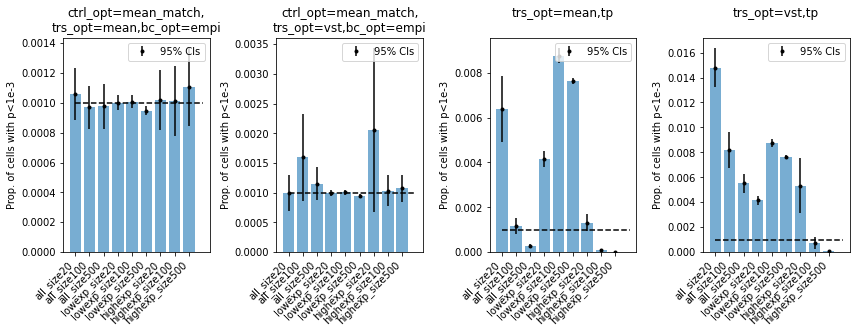

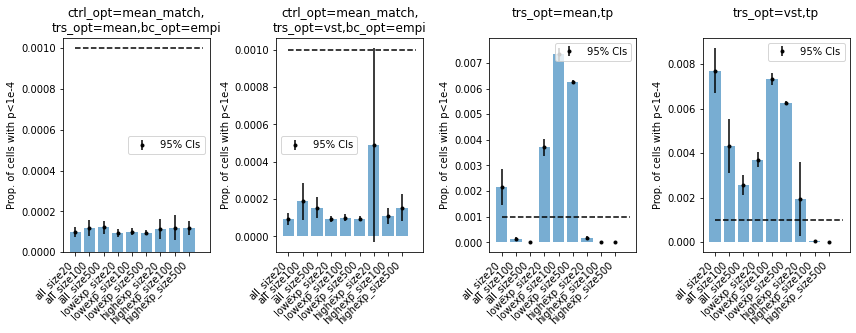

In [21]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']
md_list = ['ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=mean,bc_opt=None',
           'trs_opt=mean,tp',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=None',
           'trs_opt=vst,tp',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None',
           'trs_opt=inv_std,tp',]

md_list = ['ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi',
           'trs_opt=mean,tp',
           'trs_opt=vst,tp']

plt.figure(figsize=[12,12])
for i_mname,mname in enumerate(md_list):
    plt.subplot(3,4,i_mname+1)
    plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean.1en3'%x for x in trait_list]], alpha=0.6)
    plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean.1en3'%x for x in trait_list]],
                 yerr=1.96*df_plot.loc[mname, ['%s.se.1en3'%x for x in trait_list]],
                 color='k', fmt='.', label='95% CIs')    
    plt.plot([0, len(trait_list)],[1e-3,1e-3], linestyle='--', color='k')
    plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
    plt.ylabel('Prop. of cells with p<1e-3')
    plt.title(mname[0:20]+'\n'+mname[20:])
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=[12,12])
for i_mname,mname in enumerate(md_list):
    plt.subplot(3,4,i_mname+1)
    plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean.1en4'%x for x in trait_list]], alpha=0.6)
    plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean.1en4'%x for x in trait_list]],
                 yerr=1.96*df_plot.loc[mname, ['%s.se.1en4'%x for x in trait_list]],
                 color='k', fmt='.', label='95% CIs')    
    plt.plot([0, len(trait_list)],[1e-3,1e-3], linestyle='--', color='k')
    plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
    plt.ylabel('Prop. of cells with p<1e-4')
    plt.title(mname[0:20]+'\n'+mname[20:])
    plt.legend()
plt.tight_layout()
plt.show()

### Target appraoch

In [21]:
# Obtain TRS: This takes a lot of time.
from itertools import product
null_trait_list = list(dic_nullset.keys())
start_time = time.time()
dic_trs={}

for trait in null_trait_list:
    i_rep = int(trait.split(';')[-1].replace('rep',''))
    if i_rep > 20:
        continue

    term='%s;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
    md.score_cell(data_facs_ct, dic_nullset[trait], suffix='', 
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, 
                  return_list=['trs_ep'], verbose=False)
    dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
    print('# %-50s time=%0.1fs'%(term,time.time()-start_time))

# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6.8s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13.6s
# all_size20;rep2;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=20.4s
# all_size20;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=27.2s
# all_size20;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=34.0s
# all_size20;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=40.7s
# all_size20;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=47.7s
# all_size20;rep7;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=54.5s
# all_size20;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=61.1s
# all_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=67.9s
# all_size20;rep10;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=74.8s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=81.5s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=88.

# lowexp_size100;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=767.1s
# lowexp_size100;rep20;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=773.7s
# lowexp_size500;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=780.3s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=786.9s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=793.6s
# lowexp_size500;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=800.2s
# lowexp_size500;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=806.8s
# lowexp_size500;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=813.5s
# lowexp_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=820.1s
# lowexp_size500;rep7;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=826.7s
# lowexp_size500;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=833.3s
# lowexp_size500;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=839.9s
# lowexp_size5

In [22]:
md_list = list(set([x.split(';')[2] for x in dic_trs.keys() if 'tp' not in x]))
md_list = list(set([x.split(';')[2] for x in dic_trs.keys()]))
md_list.sort()
trait_list = list(set([x.split(';')[0] for x in dic_trs.keys()]))
trait_list.sort()
df_plot = pd.DataFrame(columns=['%s.mean'%x for x in trait_list] + ['%s.se'%x for x in trait_list] + 
                               ['%s.list'%x for x in trait_list],
                       index=md_list, data=-1)
for trait in trait_list:
    for mname in md_list:
        v_nrej = []
        for term in [x for x in dic_trs.keys() if (x.split(';')[0]==trait)&(x.split(';')[2]==mname)]:
            v_p = dic_trs[term]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nrej.append((v_fdr<0.2).sum())
        v_nrej = np.array(v_nrej)
        df_plot.loc[mname, '%s.mean'%trait] = v_nrej.mean()
        df_plot.loc[mname, '%s.se'%trait] = v_nrej.std()/np.sqrt(v_nrej.shape[0])
        df_plot.loc[mname, '%s.list'%trait] = ','.join(['%d'%x for x in v_nrej])
        print(trait, mname)

all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None


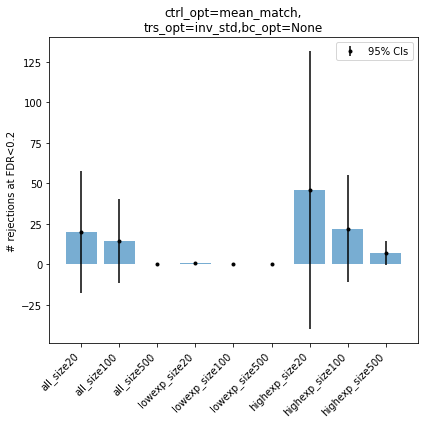

In [30]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']

plt.figure(figsize=[6,6])
mname = md_list[0]
plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]], alpha=0.6)
plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]],
             yerr=1.96*df_plot.loc[mname, ['%s.se'%x for x in trait_list]], color='k', fmt='.', label='95% CIs')
plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
plt.ylabel('# rejections at FDR<0.2')
plt.title(mname[0:20]+'\n'+mname[20:])
plt.legend()
plt.tight_layout()
plt.show()
#     break

### Old code 